In [16]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [3]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
#### Responsive params
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(dst_dir)

ROC 0.05
traces001|dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning


# Load data

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [10]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1252 |
| Lm |          1035 |
| Li |           577 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            15 |


In [11]:
counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       577 |
| Lm            |      1035 |
| V1            |      1252 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       397 |        13 |
| Lm            |       643 |        10 |
| V1            |      1031 |         9 |


In [12]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='blobs',
                        images_only=False, rename=True,
                        return_incorrect=True, return_all=False)

In [13]:
incorrect_stim.keys()

dict_keys(['20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1'])

In [14]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
rfs-dff-uncorr


In [17]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


In [18]:

data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)
                       
print(dst_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
print(FIGDIR)



traces001|dff_ROC-0.05|rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES


# Tuning curves

In [11]:
va='V1'
dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
          & (NDATA0.config.isin(configs))].copy()
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

[0, 14, 27, 40, 53, 66, 79, 92, 106]


,cell,config,response,size,morphlevel
0,0,config006,0.073549,10.0,0
1,0,config007,0.062874,20.0,0
2,0,config008,0.089596,30.0,0
3,0,config009,0.102889,40.0,0
4,0,config010,0.181599,50.0,0


In [12]:
ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf)
ixs_['visual_area'] = va
ixs_['datakey'] = dk


In [26]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [27]:

morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=True,
                                                normalize=True, return_stacked=True)
morph_curves.head()

,cell,config,response,best_size,morphlevel
0,0,config010,1.000000,50.0,0
1,0,config015,0.503044,50.0,14
2,0,config020,0.710899,50.0,27
3,0,config025,0.178752,50.0,40
4,0,config030,0.474656,50.0,53


In [28]:
#### Generate tuning curves
morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=True,
                                                normalize=True, return_stacked=True)

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, 
                                        at_best_other=True, name='morph_sel')
morph_ixs.index = morph_ixs.index.droplevel(1)
sorted_morph_ixs = morph_ixs.sort_values(by='morph_sel', ascending=False)
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, 
                                        at_best_other=True, name='size_tol')
size_tols.index = size_tols.index.droplevel(1)
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']
best_ixs.head()

,cell,size_tol,best_morphlevel,morph_sel,best_size
cell,,,,,
0,0,0.452792,0.0,0.605266,50.0
1,1,0.447143,53.0,0.175861,50.0
2,2,0.421139,53.0,0.515437,50.0
9,9,0.362837,14.0,0.360534,20.0
11,11,0.381669,79.0,0.319997,10.0


<IPython.core.display.Javascript object>


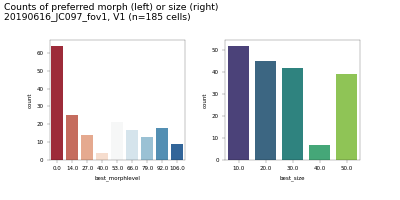

In [42]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
sns.countplot(x='best_morphlevel', data=best_ixs, ax=ax, palette='RdBu')
# ax.set_xticks(morphlevels)
ax=axn[1]
sns.countplot(x='best_size', data=best_ixs, ax=ax, palette='viridis')
n_cells = len(best_ixs['cell'].unique())
fig.text(0.01, 0.9, \
        'Counts of preferred morph (left) or size (right)\n%s, %s (n=%i cells)'\
         % (dk, va, n_cells))
pl.subplots_adjust(top=0.8, bottom=0.2, wspace=0.3)

In [47]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']
size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False
lw=0.25
rois_plot_mp = [217, 388] 
rois_plot_sz = [217, 388]

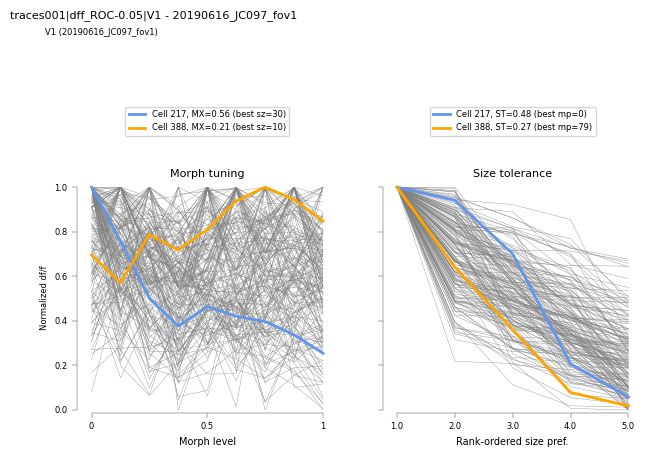

In [54]:
%matplotlib inline

fig, axn = pl.subplots(1,2, figsize=(7,5), dpi=100,sharey=True)
ax=axn[0]
rank_order=False
if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
ax.plot(mm.values, color='gray', alpha=1, lw=lw)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
    ax.plot(mm[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, MX=%.2f (best sz=%i)' 
            % (rid, best_ixs.loc[rid]['morph_sel'], best_sz))
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)
ax.set_xlabel(xlabel, fontsize=7)
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)
ax.set_ylim([0, 1])
# Size Tolerance
ax=axn[1]
rank_order=True
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0) #[::-1]
    sz = xx[::-1]
else:
    sz = size_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=lw)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['best_morphlevel'].unique())
    ax.plot(sz[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, ST=%.2f (best mp=%i)'
            % (rid, best_ixs.loc[rid]['size_tol'], best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) if rank_order else size_labels
xtick_labels = np.linspace(1, len(size_labels), len(size_labels))\
                    if rank_order else size_labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (va, dk), fontsize=6)

pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)

In [55]:
from scipy import signal

In [56]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [58]:
%matplotlib notebook
r1, r2 = rois_plot_mp
print(r1, r2)
# r1 =0
# r2= 65

stim_param = 'size'
morph_mat, size_mat = sel.get_object_tuning_curves(rdf, 
                                        sort_best_size=True, normalize=True)
val_mat = morph_mat.copy() if stim_param=='morph' else size_mat.copy()
    
curve1 = val_mat[r1].values
curve2 = val_mat[r2].values

levels = val_mat[r2].index.to_numpy() #.values
levels

217 388


array([1., 2., 3., 4., 5.])

<IPython.core.display.Javascript object>


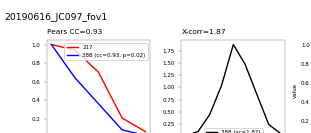

Text(0.01, 0.9, '20190616_JC097_fov1')

In [59]:
# r2 = 116
#r2 = 281
c1='r'
c2='b'
roi_colors={r1: c1, r2: c2}

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(curve1, label=r1, color=c1)
cc, pv = spstats.pearsonr(curve1, curve2)
axn[0].plot(curve2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv), color=c2)
axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=8)
axn[0].legend()

ccorr = signal.correlate(curve1, curve2)
lags = signal.correlation_lags(len(curve1), len(curve1))

#ax.legend()
lagzero = list(lags).index(0)
xcorr = ccorr[lagzero]
axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr), color='k')
axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=8)
axn[1].legend()
# --------------------------------------
ax=axn[2]
cosim_c = cr.cosine_similarity(curve1, curve2)
# d0, cosim_m = cr.get_paired_tuning_metrics(fitdf, r1, r2)
d1 = pd.DataFrame({'param': levels, 'value': curve1})
d1['cell']=r1
d2 = pd.DataFrame({'param':  levels, 'value': curve2})
d2['cell']=r2
d0 = pd.concat([d1, d2], axis=0)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True, palette=roi_colors)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
cosim_m=0
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=8)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

In [66]:
x0['morphlevel'] = sdf.loc[x0.config.values]['morphlevel'].values
x0['size'] = sdf.loc[x0.config.values]['size'].values
x0.head()

,datakey,config,trial,visual_area,cell,response,experiment,morphlevel,size
1,20190616_JC097_fov1,config023,2,V1,0,0.045070,blobs,40,30.0
2,20190616_JC097_fov1,config016,3,V1,0,-0.125729,blobs,27,10.0
3,20190616_JC097_fov1,config012,4,V1,0,0.045203,blobs,14,20.0
5,20190616_JC097_fov1,config032,6,V1,0,-0.042532,blobs,66,20.0
6,20190616_JC097_fov1,config042,7,V1,0,0.088752,blobs,92,20.0


In [74]:
best_sz = best_ixs.loc[r1]['best_size']
best_mp = best_ixs.loc[r1]['best_morphlevel']

roi_resp = x0[(x0.cell==r1)].copy()


<IPython.core.display.Javascript object>


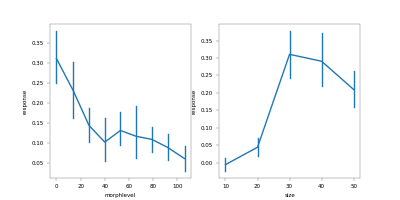

<AxesSubplot:xlabel='size', ylabel='response'>

In [75]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
sns.lineplot(x='morphlevel', y='response', ax=ax,
             data=roi_resp[roi_resp['size']==best_sz], err_style='bars')
ax=axn[1]
sns.lineplot(x='size', y='response',  ax=ax,
            data=roi_resp[roi_resp['morphlevel']==best_mp], err_style='bars')

In [573]:
DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk) 
     & (DISTS.neuron_pair=='%i_%i' % (r1, r2))]

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance,visual_area,datakey,n_cells
71179,3.494241,-0.656121,0.862276,217,388,217_388,1.872899,0.934599,0.967453,NaN,NaN,NaN,273.631709,V1,20190616_JC097_fov1,185


In [294]:
rois_ = rdf['cell'].unique()
col_pairs = list(itertools.combinations(rois_, 2))  

In [295]:
rdf_sub = rdf.copy()
rdf_sub = sel.subtract_min(rdf_sub)
rdf_sub.min()

cell                  0
config        config006
response            0.0
size               10.0
morphlevel            0
dtype: object

In [387]:
cc = cr.get_pw_curve_correlations(rdf, stimulus='blobs')

<IPython.core.display.Javascript object>


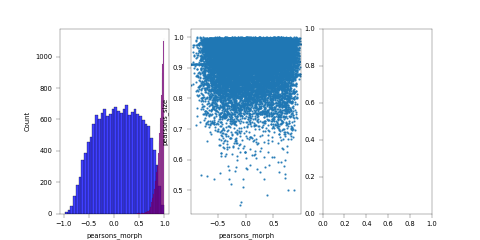

<AxesSubplot:xlabel='pearsons_morph', ylabel='pearsons_size'>

In [378]:
metric = 'pearsons'
fig, axn = pl.subplots(1,3, figsize=(6,3))
ax=axn[0]
sns.histplot(x='%s_morph' % metric, data=cc, ax=ax, color='blue')
sns.histplot(x='%s_size' % metric, data=cc, ax=ax, color='purple')

ax=axn[1]
sns.regplot(x='%s_morph' % metric,y='%s_size' % metric, data=cc, ax=ax,
           scatter_kws={'s':1})

In [391]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [470]:
rdf['experiment'] = 'blobs'
posdf = cr.get_roi_pos_and_rfs(rdf, curr_rfs=curr_rfs, rfs_only=False, 
                   merge_cols=['visual_area', 'datakey', 'cell'])
print(posdf.shape)

(185, 7)


In [399]:
cc = cr.get_pw_curve_correlations(rdf, stimulus='blobs')   
cc.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609


In [409]:
diffs_ = cc.copy()
# adist = cr.get_pw_distance(diffs_, curr_rfs, xcoord='ml_pos', ycoord='ap_pos',
#                         label='cortical_distance')
adist = cr.get_pw_distance(diffs_, posdf, xcoord='x0', ycoord='y0',
                        label='rf_distance')
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,129.947597


In [410]:
cc.shape, adist.shape

((17020, 9), (17020, 11))

<IPython.core.display.Javascript object>


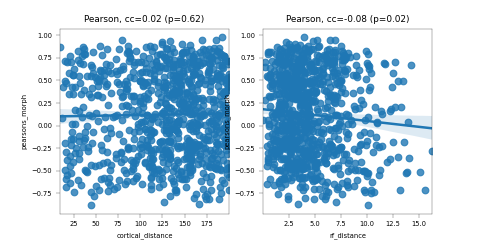

Text(0.5, 1.0, 'Pearson, cc=-0.08 (p=0.02)')

In [444]:
metric='pearsons'
y_var = '%s_morph' % metric
x_var = 'cortical_distance'
plotd=adist[adist.cortical_distance<200].copy()
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))

x_var = 'rf_distance'
ax=axn[1]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))


In [429]:
import copy

In [440]:
df = adist.copy()
# Split distances into X um bins
ctx_step=25
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


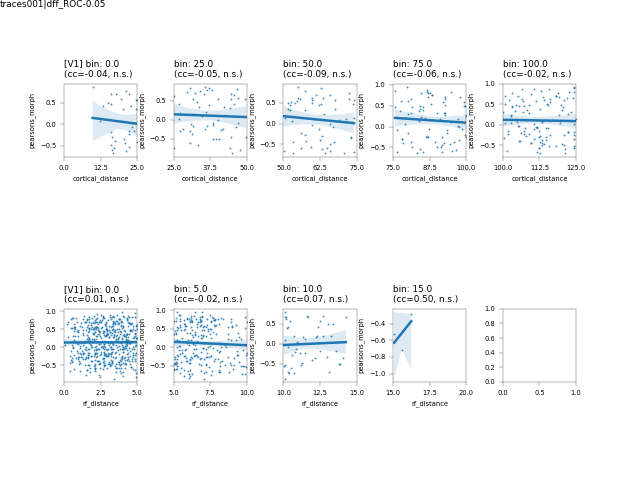

In [445]:
%matplotlib notebook

vg=df[(df.cortical_distance<200) ].copy()


y_var='pearsons_morph'

scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(2, n_bins_plot, figsize=(8,6))

dist_var = 'cortical_distance'
for ri, dist_var in enumerate(['cortical_distance', 'rf_distance']):
    dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[ri, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %.1f\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)


# Aggregate

In [19]:
# response_type='dff'
# do_spherical_correction=False
# rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
#                               response_type=response_type,
#                               do_spherical_correction=do_spherical_correction,
#                               reliable_only=True,
#                               pass_criterion='position')
# rfdf = aggr.add_roi_positions(rfdf)

In [20]:
# posdf = cr.get_roi_pos_and_rfs(rdf, curr_rfs=curr_rfs, rfs_only=False, 
#                    merge_cols=['visual_area', 'datakey', 'cell'])
# print(posdf.shape)

In [21]:
# va='V1'
# dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

rdf_list=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    if with_lum:
        configs = sdf.index.tolist()
    else:
        configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    sizes = list(sorted(sdf['size'].unique()))
    morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
    
    x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
              & (NDATA0.config.isin(configs))].copy()
    rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
             .mean().reset_index().drop('trial', axis=1)
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
    rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf['size'] = sdf.loc[rdf['config']]['size'].values
    rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
    rdf_list.append(rdf)
avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
avg_responses['experiment'] = 'blobs'

In [28]:
has_rfs = pd.concat([g for (va, dk), g in rfdf.groupby(['visual_area', 'datakey'])
            if not avg_responses.query('@va==visual_area and @dk==datakey').empty])
has_rfs.head()

,datakey,cell,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
54,20190602_JC091_fov1,14,36.413696,-2.266471,59.205810,26.710587,0.030140,-0.005633,0.025537,0.633365,...,average_rfs,JC091,FOV1_zoom2p0x,20190602,108.311546,47.0,447.373777,235.0,525.426223,1069.288454
55,20190602_JC091_fov1,15,30.181381,-9.810488,41.089474,25.988467,0.149166,-0.008335,0.069465,0.632106,...,average_rfs,JC091,FOV1_zoom2p0x,20190602,138.270059,60.0,437.855186,230.0,534.944814,1039.329941
56,20190602_JC091_fov1,16,28.679054,-7.147786,30.018364,19.768519,0.072316,-0.007893,0.129596,0.774476,...,average_rfs,JC091,FOV1_zoom2p0x,20190602,138.270059,60.0,449.277495,236.0,523.522505,1039.329941
57,20190602_JC091_fov1,22,28.183510,-11.676374,48.502411,32.024117,0.159074,-0.014291,0.101274,0.760267,...,average_rfs,JC091,FOV1_zoom2p0x,20190602,179.751076,78.0,388.358513,204.0,584.441487,997.848924
58,20190602_JC091_fov1,23,32.025122,-12.568957,49.195645,22.499418,6.193660,-0.005793,0.084204,0.635829,...,average_rfs,JC091,FOV1_zoom2p0x,20190602,156.706067,68.0,426.432877,224.0,546.367123,1020.893933


In [35]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [36]:
# Calculate distances
DISTS = cr.aggregate_tuning_curve_ccdist(avg_responses, rfdf=rfdf, 
                                         rfpolys=rfpolys,
                                         min_ncells=5, stimulus='blobs')

    (20190315_JC070_fov1 NONE, skipping overlaps)
    (20190316_JC070_fov1 NONE, skipping overlaps)
too few cells: Li, 20190319_JC067_fov1
too few cells: Li, 20190320_JC067_fov1
too few cells: Li, 20190321_JC070_fov1
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190617_JC099_fov1 NONE, skipping overlaps)
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
too few cells: Lm, 20191111_JC120_fov1
[]


In [128]:
DISTS['area_overlap'] = DISTS['area_overlap'].astype(float)
DISTS['perc_overlap'] = DISTS['perc_overlap'].astype(float)

DISTS.groupby('visual_area').count()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,cortical_distance,area_overlap,perc_overlap,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,10770,10770,10770,10770,10770,10770,10770,10770,10770,10770,...,10770,2868,2868,1940,1940,1940,1940,1940,10770,10770
Lm,28864,28864,28864,28864,28864,28864,28864,28864,28864,28864,...,28864,2735,2735,2463,2463,2463,2463,2463,28864,28864
V1,74551,74551,74551,74551,74551,74551,74551,74551,74551,74551,...,74551,20921,20921,18307,18307,18307,18307,18307,74551,74551


In [129]:
va='V1'
dk='20190616_JC097_fov1'
test_a = DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk)].copy()
test_a.shape, adist.shape

NameError: name 'adist' is not defined

In [130]:
import copy

In [131]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


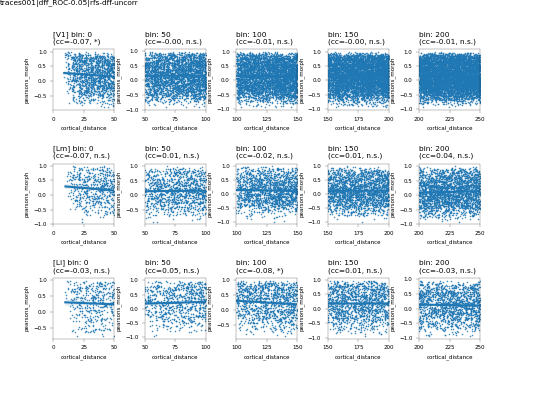

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning pearsons_morph_v_binCTX_50um


In [132]:
%matplotlib notebook
y_var='pearsons_morph'
dist_var = 'cortical_distance'
# -------------------------------------------------------------
dist_str='VF' if dist_var=='rf_distance' else 'CTX'
dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
dist_step = rf_step if dist_var=='rf_distance' else ctx_step
dist_unit = 'deg' if dist_var=='rf_distance' else 'um'
#
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,6))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_bin%s_%i%s' % (y_var, dist_str, dist_step, dist_unit)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [158]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

<IPython.core.display.Javascript object>


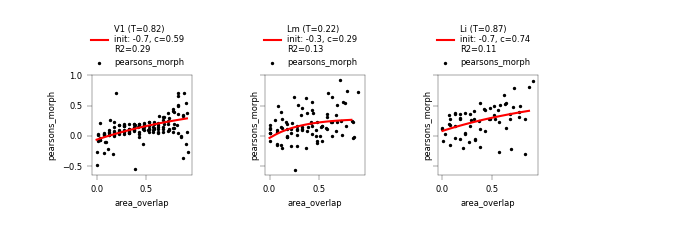

In [160]:
%matplotlib notebook
metric='pearsons_morph'
to_quartile = 'area_overlap'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' \
    else to_quartile
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), dpi=150, sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index() #.dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
       #ax.set_title(va)
    #ax.set_xlim([0, 250])
   # ax.set_xlim([0, 40])
    #ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [196]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

<IPython.core.display.Javascript object>


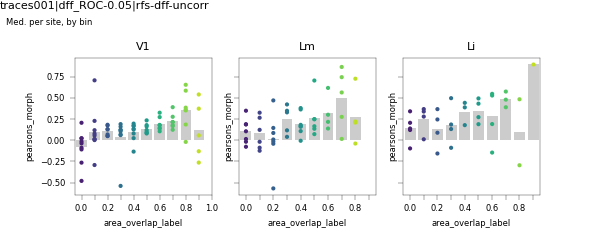

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning area_overlap_label_v_pearsons_morph_barplot_byFOV


In [197]:
x_bins = perc_bins.copy()
fig, axn = pl.subplots(1,3, figsize=(6,2.5), dpi=150, sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    by_fov = cc0.groupby([x_var, 'datakey']).median().reset_index()
    ax=axn[visual_areas.index(va)]
    sns.barplot(x=x_var, y=metric, data=by_fov, ax=ax, ci=None, 
               color=[0.8]*3)
    sns.stripplot(x=x_var, y=metric, data=by_fov, ax=ax, size=3,
                 palette='viridis', hue=x_var, jitter=False)
    ax.legend_.remove()
    ax.set_box_aspect(1)
    ax.set_title(va)
#     ax.set_xticks()
#             whis=(5, 95))
    ax.set_xticks(np.arange(0, len(x_bins)))
    ax.set_xticklabels([round(i,1) if i in x_bins[0::2] else '' for i in x_bins])

fig.text(0.01, 0.9, 'Med. per site, by bin')
pplot.label_figure(fig, data_id)

figname = '%s_v_%s_barplot_byFOV' % (x_var, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [178]:
x_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

## Bootstrap

In [182]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

In [183]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='pearsons_morph'
to_quartile='area_overlap'
# --------------------------------------------------
cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=100
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
    val out of bounds
    val out of bounds
    val out of bounds
(0, 6)


In [184]:

print("init: %i/%i iters too big" % (resdf[resdf.init>1].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=-1].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>200].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))


init: 0/100 iters too big
init: 0/100 iters too small
tau: 0/100 iters too big
tau: 297/100 iters too small


In [185]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1.2) & (resdf['init']>=-1.2) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(297, 6) (297, 6)


In [186]:
import _pickle as pkl


In [187]:
stim_str = '' 
select_stimuli='images'
if experiment in ['gratings', 'blobs']:
    if select_stimuli!='images':
        stim_str = '_FF' if select_stimuli=='fullfield' else '_%s' % select_stimuli

results_fpath = os.path.join(dst_dir, '%s_%s%s.pkl' % (to_quartile, bin_type, stim_str))
with open(results_fpath, 'wb') as f:
    pkl.dump(resdf, f, protocol=2)
print('saved: %s' % results_fpath)

saved: /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/area_overlap_cut-fitraw-avgfov.pkl


In [188]:
finalres.dropna().groupby('visual_area').count()

,init,tau,constant,R2,iteration
visual_area,,,,,
Li,97,97,97,97,97
Lm,100,100,100,100,100
V1,100,100,100,100,100


RF overlap (%)


<IPython.core.display.Javascript object>


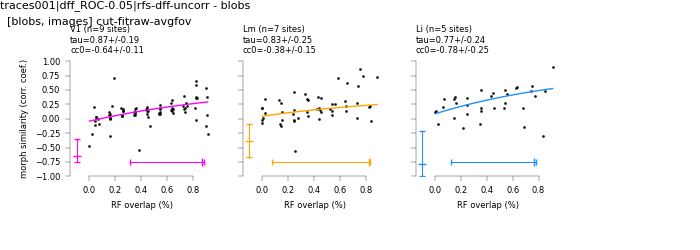

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning area_overlap_curves_cut-fitraw-avgfov


In [198]:
x_pos = -100 if to_quartile=='cortical_distance' else -10
x_pos = -0.1
xlabel='cortical distance (um)' #if to_quartile=='cortical_distance' \
xlabel='RF distance (deg)'
xlabel='RF overlap (%)'
ylabel='morph similarity (corr. coef.)'
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 1), xlabel=xlabel, ylabel=ylabel)
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s%s' % (to_quartile, bin_type, stim_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### parameter estimates, 95% CI

<IPython.core.display.Javascript object>


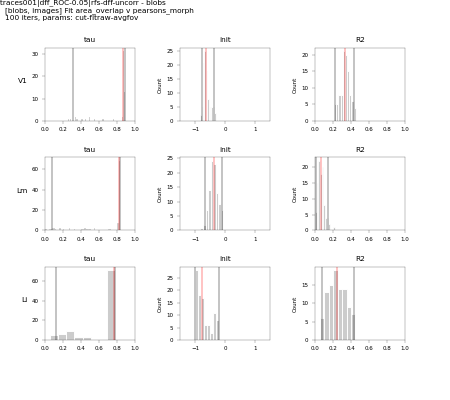

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning param_distns_area_overlap_cut-fitraw-avgfov


In [194]:
tau_lim=1200 if to_quartile=='cortical_distance' else 80
tau_lim = 1
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
for va, rd_ in finalres.groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.95, "[%s, %s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, select_stimuli, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_%s%s' % (to_quartile, bin_type, stim_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


RF distance (deg)


<IPython.core.display.Javascript object>


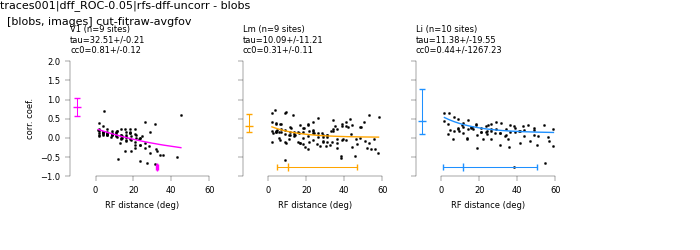

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning rf_distance_curves_cut-fitraw-avgfov


In [72]:
x_pos = -100 if to_quartile=='cortical_distance' else -10
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, xlabel=xlabel,
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 2), )
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s%s' % (to_quartile, bin_type, stim_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,V1,20190616_JC097_fov1,0,909.977299,1078.506458,34.263130,-10.628686
1,V1,20190616_JC097_fov1,1,864.288063,1099.246967,NaN,NaN
2,V1,20190616_JC097_fov1,2,852.865753,1073.897456,30.848143,-6.732552
3,V1,20190616_JC097_fov1,9,873.806654,1023.198434,39.429009,-3.330024
4,V1,20190616_JC097_fov1,11,883.325245,993.239922,35.470047,-12.506376
...,...,...,...,...,...,...,...
180,V1,20190616_JC097_fov1,424,207.505284,1048.547945,29.780096,-2.802732
181,V1,20190616_JC097_fov1,425,32.363209,772.007828,20.431419,-7.071060
182,V1,20190616_JC097_fov1,426,45.689237,811.184344,NaN,NaN
183,V1,20190616_JC097_fov1,429,138.971429,520.817221,20.485330,-13.131780


In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN,NaN,50.176439
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,35.873821,31.574280,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,39.569379,35.873821,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,37.610287,35.873821,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,40.524749,35.873821,129.947597


In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

,visual_area,datakey,cell,config,response,size,morphlevel,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,V1,20190616_JC097_fov1,0,config006,0.073549,10.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
1,V1,20190616_JC097_fov1,0,config007,0.062874,20.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
2,V1,20190616_JC097_fov1,0,config008,0.089596,30.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
3,V1,20190616_JC097_fov1,0,config009,0.102889,40.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
4,V1,20190616_JC097_fov1,0,config010,0.181599,50.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,V1,20190616_JC097_fov1,431,config046,0.047672,10.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8321,V1,20190616_JC097_fov1,431,config047,0.014780,20.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8322,V1,20190616_JC097_fov1,431,config048,0.016424,30.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8323,V1,20190616_JC097_fov1,431,config049,0.016479,40.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890


In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)